<a href="https://colab.research.google.com/github/NishilJ/CS-4372-ML-DS/blob/main/CS4372_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import kagglehub
import splitfolders
from PIL import Image
import glob

In [ ]:
# Download latest version
data = kagglehub.dataset_download("abdulhasibuddin/uc-merced-land-use-dataset")

print("Path to dataset files:", data)

Using Colab cache for faster access to the 'uc-merced-land-use-dataset' dataset.
Path to dataset files: /kaggle/input/uc-merced-land-use-dataset


In [ ]:
input_folder = os.path.join(data, "UCMerced_LandUse", "Images")
output_folder = "data_split"

splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=1337,
    ratio=(0.6, 0.40)  # 60% train, 40% val/test
)


Copying files: 2100 files [00:03, 579.21 files/s]


In [ ]:
# Tiff to JPG
def convert_tif_to_jpg(input_folder, output_folder):
    # Converts all .tif images in input_folder to .jpg in output_folder.
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filepath in glob.glob(os.path.join(input_folder, '**', '*.tif'), recursive=True):
        try:
            img = Image.open(filepath)
            # Create the corresponding output directory structure
            relative_path = os.path.relpath(os.path.dirname(filepath), input_folder)
            output_dir = os.path.join(output_folder, relative_path)
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)

            # Change extension to .jpg
            filename = os.path.splitext(os.path.basename(filepath))[0] + '.jpg'
            output_filepath = os.path.join(output_dir, filename)

            # Convert and save
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img.save(output_filepath, 'JPEG')
            print(f"Converted {filepath} to {output_filepath}")
        except Exception as e:
            print(f"Error converting {filepath}: {e}")

# Convert images in train, val, and test directories
convert_tif_to_jpg("data_split/train", "data_split_jpg/train")
convert_tif_to_jpg("data_split/val", "data_split_jpg/val")

Converted data_split/train/storagetanks/storagetanks22.tif to data_split_jpg/train/storagetanks/storagetanks22.jpg
Converted data_split/train/storagetanks/storagetanks05.tif to data_split_jpg/train/storagetanks/storagetanks05.jpg
Converted data_split/train/storagetanks/storagetanks10.tif to data_split_jpg/train/storagetanks/storagetanks10.jpg
Converted data_split/train/storagetanks/storagetanks32.tif to data_split_jpg/train/storagetanks/storagetanks32.jpg
Converted data_split/train/storagetanks/storagetanks19.tif to data_split_jpg/train/storagetanks/storagetanks19.jpg
Converted data_split/train/storagetanks/storagetanks55.tif to data_split_jpg/train/storagetanks/storagetanks55.jpg
Converted data_split/train/storagetanks/storagetanks35.tif to data_split_jpg/train/storagetanks/storagetanks35.jpg
Converted data_split/train/storagetanks/storagetanks37.tif to data_split_jpg/train/storagetanks/storagetanks37.jpg
Converted data_split/train/storagetanks/storagetanks53.tif to data_split_jpg/tra

In [ ]:
img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "data_split_jpg/train", image_size=img_size, batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "data_split_jpg/val", image_size=img_size, batch_size=batch_size
)

Found 1260 files belonging to 21 classes.
Found 840 files belonging to 21 classes.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

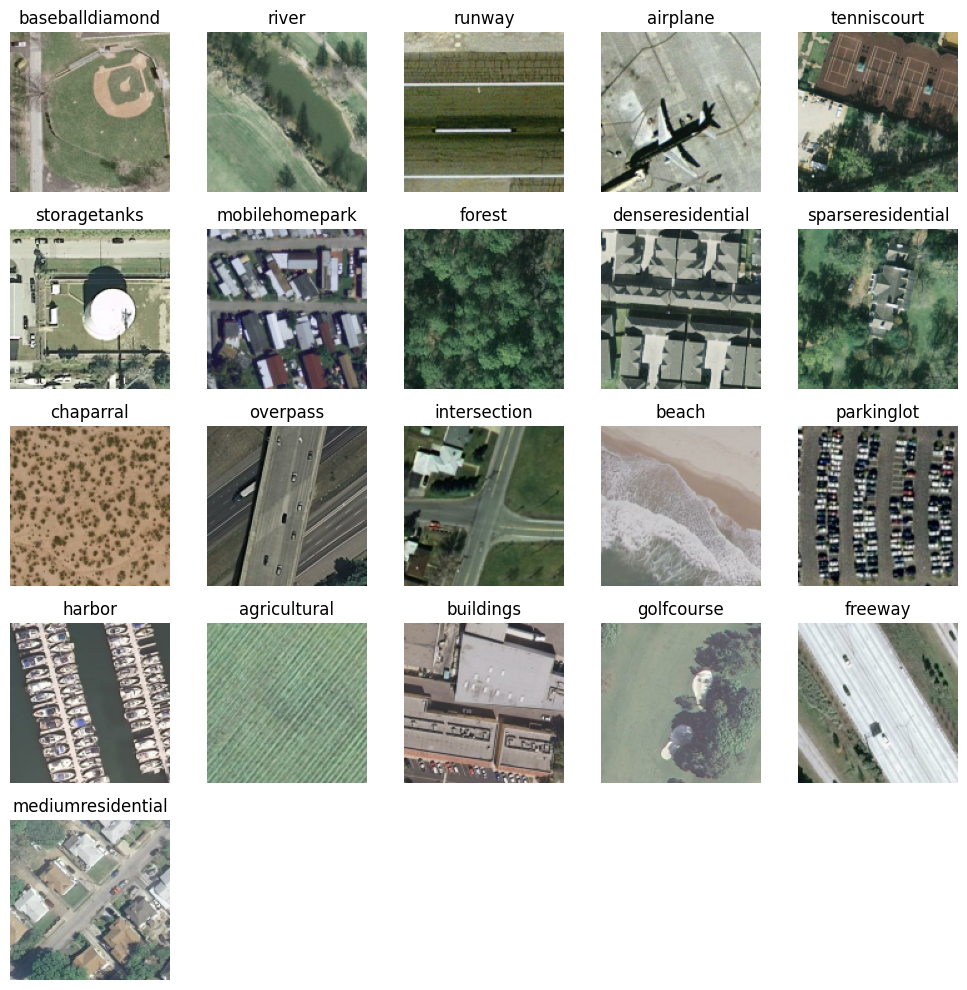

In [ ]:
# Get class names from the dataset
class_names = train_ds.class_names

# Track which classes we’ve already shown
seen_classes = set()
plt.figure(figsize=(10, 10))
count = 0

# Loop through the entire dataset, one image at a time
for image, label in train_ds.unbatch():
    label_idx = int(label.numpy())
    if label_idx not in seen_classes:
        ax = plt.subplot(5, 5, count + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[label_idx])
        plt.axis("off")
        seen_classes.add(label_idx)
        count += 1
    if count == len(class_names):
        break

plt.tight_layout()
plt.show()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_pf = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds_pf = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds_pf = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def build_model(dense_units, dropout_rate, learning_rate, trainable_layers):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(*img_size, 3),
        include_top=False,
        weights='imagenet'
    )

    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Tuning loop
param_combinations = [
    {'dense_units': 64,  'dropout_rate': 0.3, 'learning_rate': 0.01,  'trainable_layers': 0},
    {'dense_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01,  'trainable_layers': 20},
    {'dense_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'trainable_layers': 40},
    {'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001,  'trainable_layers': 20},
    {'dense_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'trainable_layers': 40},
]

best_val_acc = 0
best_model = None
best_hist = None
results = []
for params in param_combinations:
    model = build_model(**params)
    hist = model.fit(train_ds_pf, validation_data=val_ds_pf, epochs=5, verbose=1)
    val_acc = hist.history['val_accuracy'][-1]

    # Save best model and history
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_hist = hist

    results.append({
        'Activation Hidden': 'ReLU',
        'Activation Output': 'Softmax',
        'Dropout': params['dropout_rate'],
        'Learning Rate': params['learning_rate'],
        'Trainable Layers': params['trainable_layers'],
        'Train Accuracy': hist.history['accuracy'][-1],
        'Validation Accuracy': val_acc
    })

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.1141 - loss: 3.3179 - val_accuracy: 0.0500 - val_loss: 6.6936
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.1643 - loss: 2.6683 - val_accuracy: 0.0471 - val_loss: 6.6626
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.2256 - loss: 2.4699 - val_accuracy: 0.0500 - val_loss: 6.3326
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2587 - loss: 2.1824 - val_accuracy: 0.0544 - val_loss: 7.0490
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.2579 - loss: 2.1326 - val_accuracy: 0.0471 - val_loss: 12.5781
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 718ms/step - accuracy: 0.3894 - loss: 2.7451 - val_accuracy: 0.0956 - val_loss: 10.6698
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 666ms/step - accuracy: 0.7626 - loss: 0.8841 - val_accuracy: 0.1000 - val_loss: 4.8598
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 669ms/step - accuracy: 0.8581 - loss: 0.4844 - val_accuracy: 0.1000 - val_

In [ ]:
import pandas as pd
print(pd.DataFrame(results))

  Activation Hidden Activation Output  Dropout  Learning Rate  \
0              ReLU           Softmax      0.3         0.0100   
1              ReLU           Softmax      0.3         0.0100   
2              ReLU           Softmax      0.4         0.0010   
3              ReLU           Softmax      0.4         0.0010   
4              ReLU           Softmax      0.5         0.0001   

   Trainable Layers  Train Accuracy  Validation Accuracy  
0                 0        0.265079             0.047059  
1                20        0.899206             0.157353  
2                40        0.957143             0.258824  
3                20        0.961905             0.645588  
4                40        0.953175             0.822059  


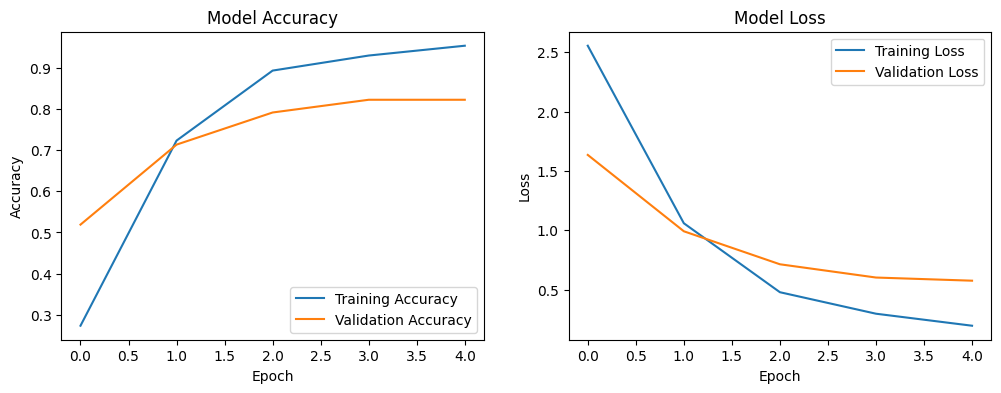

In [ ]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(best_hist.history['accuracy'], label='Training Accuracy')
plt.plot(best_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(best_hist.history['loss'], label='Training Loss')
plt.plot(best_hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


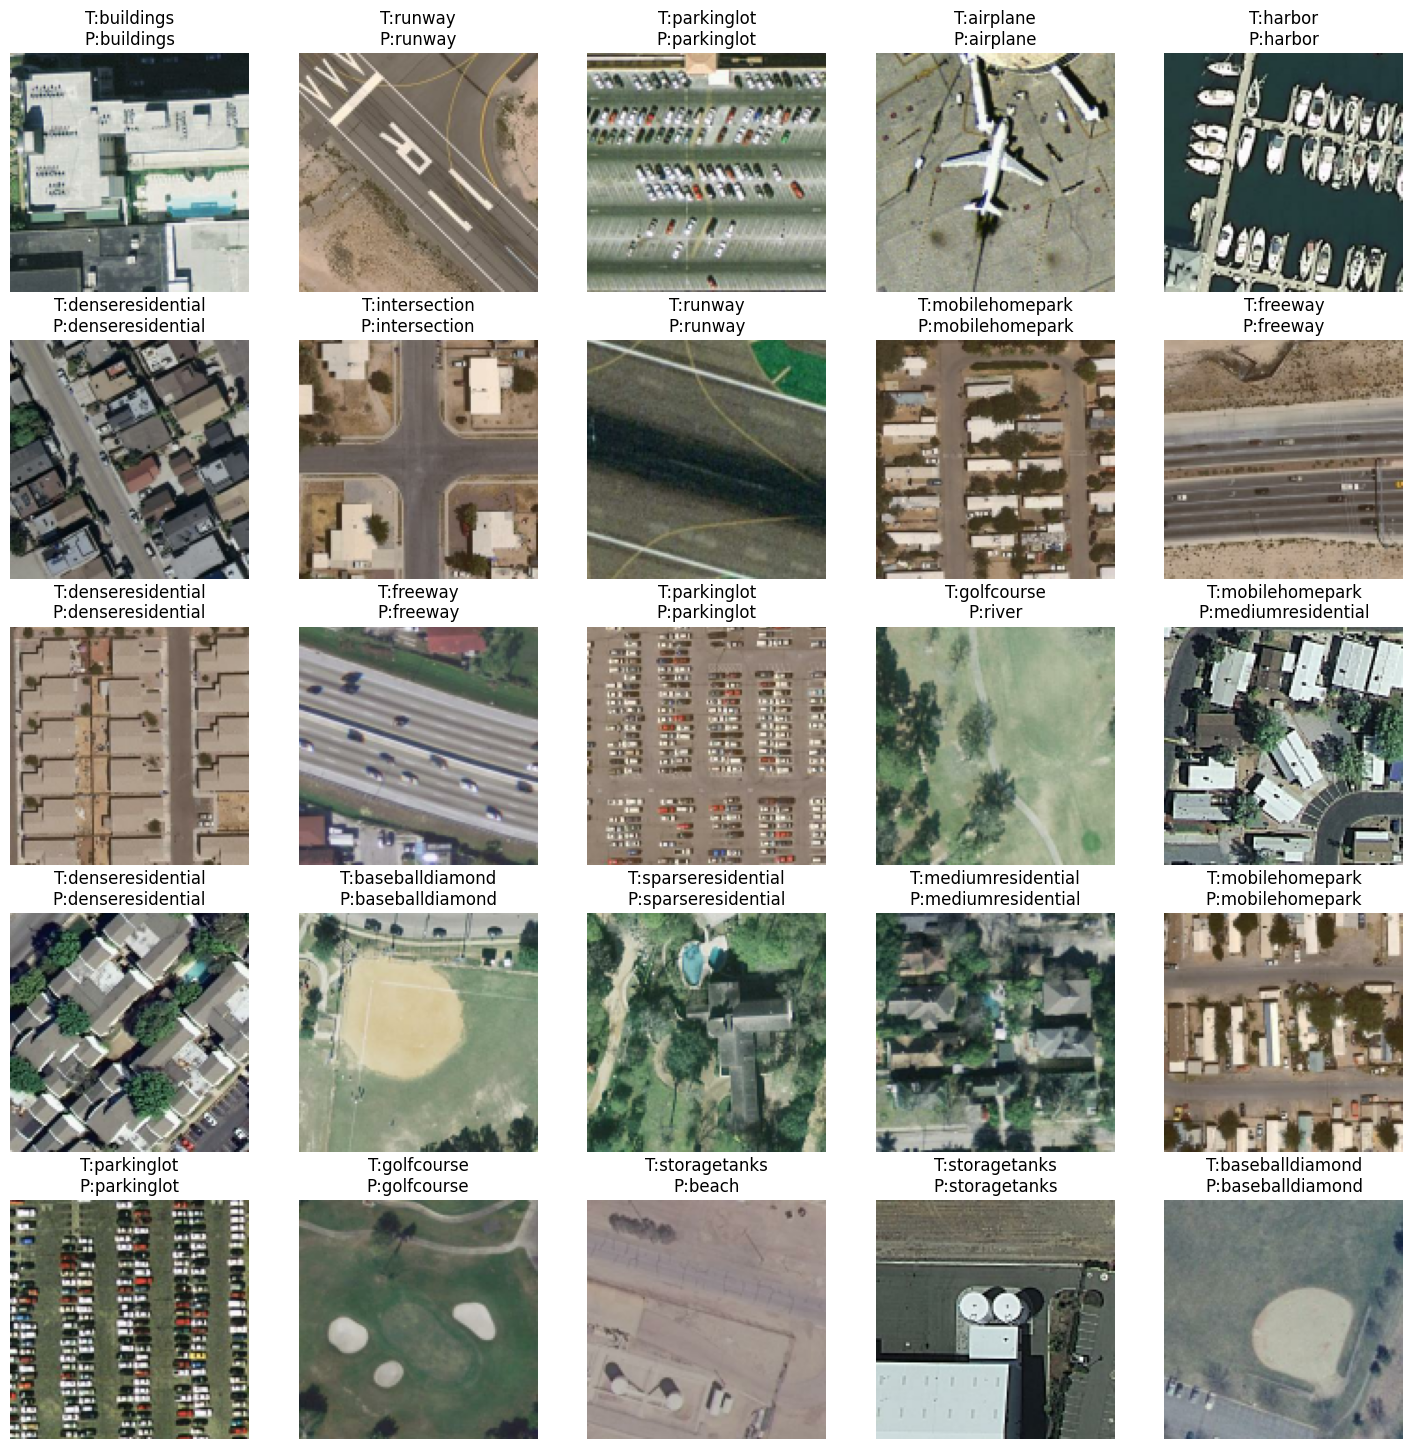

In [ ]:
# Get class names from the original dataset object
class_names = train_ds.class_names
for images, labels in test_ds.take(1):
    preds = best_model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    plt.figure(figsize=(18,18))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"T:{class_names[labels[i]]}\nP:{class_names[pred_labels[i]]}")
        plt.axis("off")